In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df_train = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')
combined_data_list = [df_train, df_test]
combined_data = pd.concat([df_train.drop(columns='SalePrice'), df_test])

In [3]:
def isnull_stats(df, isnull_text_addition):
    df = pd.DataFrame(df.isnull().sum())/df.shape[0] * 100
    df = df.reset_index()
    df.columns = ['feature', 'isnull_' + isnull_text_addition + '_%']
    df['isnull_' + isnull_text_addition + '_%'] = df['isnull_' + isnull_text_addition + '_%'].apply(lambda x: int(x*100) / 100)
    df = df[df['isnull_' + isnull_text_addition + '_%']!=0].sort_values('isnull_' + isnull_text_addition + '_%', ascending=False)
    return df

def isnull_train_test_stats(df_train, df_test):
    df_train_missing_values = isnull_stats(df=df_train, isnull_text_addition='train')
    df_test_missing_values = isnull_stats(df=df_test, isnull_text_addition='test')
    df_together_missing_values = df_train_missing_values.merge(df_test_missing_values, on='feature', how='outer').fillna(0)
    col_names = df_together_missing_values.columns
    df_together_missing_values['abs_diff_%'] = abs(df_together_missing_values[col_names[1]] - df_together_missing_values[col_names[2]])

    df_dtypes = df_train.dtypes.reset_index()
    df_dtypes.columns = ['feature', 'dtype']

    df_together_missing_values = df_together_missing_values.merge(df_dtypes, on='feature')

    return df_together_missing_values

df_missing_values = isnull_train_test_stats(df_train, df_test)
df_missing_values

,feature,isnull_train_%,isnull_test_%,abs_diff_%,dtype
0,PoolQC,99.52,99.79,0.27,object
1,MiscFeature,96.30,96.50,0.20,object
2,Alley,93.76,92.66,1.10,object
3,Fence,80.75,80.12,0.63,object
4,FireplaceQu,47.26,50.03,2.77,object
5,LotFrontage,17.73,15.55,2.18,float64
6,GarageType,5.54,5.20,0.34,object
7,GarageYrBlt,5.54,5.34,0.20,float64
8,GarageFinish,5.54,5.34,0.20,object
9,GarageQual,5.54,5.34,0.20,object


In [4]:
def dealing_with_missing_values(df_missing_values, combined_data, missing_val_threshold, gen_number_fillna, gen_obj_fillna):
    values_to_drop_due_threshold = df_missing_values[df_missing_values['isnull_train_%'] >= missing_val_threshold*100]
    values_to_drop_due_threshold = list(values_to_drop_due_threshold.feature)
    print('drop due threshhold ' + str(missing_val_threshold) + ': ', values_to_drop_due_threshold)
    df_missing_values_below_threshold = df_missing_values[~df_missing_values['feature'].isin(values_to_drop_due_threshold)]

    obj_colnames = df_missing_values_below_threshold[df_missing_values_below_threshold['dtype'] == 'object'].feature

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_colnames = combined_data.select_dtypes(include=numerics).columns    

    if gen_obj_fillna == 'most_freq':
        obj_col_fillna_dict = {}
        for col_name in obj_colnames:
          obj_col_fillna_dict[col_name] = combined_data[col_name].value_counts().reset_index().loc[0, 'index']
    else:
        print('there is no method like this:', gen_obj_fillna)
        return

    if gen_number_fillna == 'median':
        num_col_fillna_dict = {}
        for col_name in num_colnames:
          num_col_fillna_dict[col_name] = combined_data[col_name].median()
    elif gen_number_fillna == 'mean':
        num_col_fillna_dict = {}
        for col_name in num_colnames:
          num_col_fillna_dict[col_name] = combined_data[col_name].mean()
    else:
        print('there is no method like this:', gen_number_fillna)
        return

    dict_for_missing_values = obj_col_fillna_dict | num_col_fillna_dict
    df_missing_values['fillna_value'] = df_missing_values['feature'].map(dict_for_missing_values)
    return df_missing_values

df_missing_values = dealing_with_missing_values(df_missing_values, combined_data, missing_val_threshold=0.7, gen_number_fillna='mean', gen_obj_fillna='most_freq')

drop due threshhold 0.7:  ['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [5]:
def strat_fillna(df_missing_values, combined_data, missing_val_threshold, strat_for_fillna, gen_number_fillna, gen_obj_fillna):
    values_to_drop_due_threshold = df_missing_values[df_missing_values['isnull_train_%'] >= missing_val_threshold*100]
    values_to_drop_due_threshold = list(values_to_drop_due_threshold.feature)
    print('drop due threshhold ' + str(missing_val_threshold) + ': ', values_to_drop_due_threshold)
    df_missing_values_below_threshold = df_missing_values[~df_missing_values['feature'].isin(values_to_drop_due_threshold)]
    
    obj_colnames = df_missing_values_below_threshold[df_missing_values_below_threshold['dtype'] == 'object'].feature
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_colnames = combined_data.select_dtypes(include=numerics).columns

    # получить значения по strat_for_fillna по которым будем бегать (если есть отсутствующие - заменить на само часто встречающееся)
    most_freq_strat = combined_data[strat_for_fillna].value_counts().reset_index().iloc[0,0]
    combined_data[strat_for_fillna] = combined_data[strat_for_fillna].fillna(most_freq_strat)

    strat_for_fillna_values = list(combined_data[strat_for_fillna].unique())
    missing_features = list(df_missing_values['feature'])
    first_oper_flag = 1


    for strat_value in strat_for_fillna_values:
        # тут нужно брать каждую переменную из df_missing_values и по стратам брать подвыборку
        df_strat = pd.DataFrame(combined_data[combined_data[strat_for_fillna] == strat_value])
        if gen_obj_fillna == 'most_freq':
            for col_name in obj_colnames:
                df_strat[col_name] = df_strat[col_name].fillna(df_strat[col_name].value_counts().reset_index().loc[0, 'index'])
        else:
            print('there is no method like this:', gen_obj_fillna)
            return

        if gen_number_fillna == 'median':
            for col_name in num_colnames:
                df_strat[col_name] = df_strat[col_name].fillna(df_strat[col_name].median())
        elif gen_number_fillna == 'mean':
            num_col_fillna_dict = {}
            for col_name in num_colnames:
                df_strat[col_name] = df_strat[col_name].fillna(df_strat[col_name].mean())
        else:
            print('there is no method like this:', gen_number_fillna)
            return


        if first_oper_flag == 1:
            df_result = pd.DataFrame(df_strat)
            first_oper_flag = 0
        else:
            df_result = pd.concat([df_result, df_strat])

    df_result = df_result.drop(columns=values_to_drop_due_threshold)
    return df_result


strat_fillna_combined_data = strat_fillna(df_missing_values, combined_data, missing_val_threshold=0.7, strat_for_fillna='MSZoning', gen_number_fillna='mean', gen_obj_fillna='most_freq')

drop due threshhold 0.7:  ['PoolQC', 'MiscFeature', 'Alley', 'Fence']


In [6]:
# that was an old algo. I've added stats to fillna function and wanna try new approach

# def fill_missing_values(df, df_missing_values):
#     for feature in df_missing_values.feature:
#         if ~pd.isnull(df_missing_values[df_missing_values['feature'] == feature]['fillna_value']).iloc[0]:
#             fillna_val = df_missing_values[df_missing_values['feature'] == feature]['fillna_value'].iloc[0]
#             df[feature] = df[feature].fillna(fillna_val)
#         else:
#             df = df.drop(columns=feature)

#     return df

# df_train = fill_missing_values(df_train, df_missing_values)
# df_test = fill_missing_values(df_test, df_missing_values)

# --------------------------------------------------------

df_train = df_train[['SalePrice']].merge(strat_fillna_combined_data, left_index=True, right_index=True)
df_test = pd.merge(strat_fillna_combined_data, df_train[['SalePrice']], left_index=True, right_index=True, how='outer', indicator=True).query("_merge != 'both'").drop(columns=['_merge','SalePrice'])

[('SalePrice', 'OverallQual'), ('SalePrice', 'TotalBsmtSF'), ('SalePrice', '1stFlrSF'), ('SalePrice', 'GrLivArea'), ('SalePrice', 'GarageCars'), ('SalePrice', 'GarageArea'), ('OverallQual', 'GarageCars'), ('YearBuilt', 'GarageYrBlt'), ('YearRemodAdd', 'GarageYrBlt'), ('BsmtFinSF1', 'BsmtFullBath'), ('TotalBsmtSF', '1stFlrSF'), ('2ndFlrSF', 'GrLivArea'), ('2ndFlrSF', 'HalfBath'), ('2ndFlrSF', 'TotRmsAbvGrd'), ('GrLivArea', 'FullBath'), ('GrLivArea', 'TotRmsAbvGrd'), ('BedroomAbvGr', 'TotRmsAbvGrd'), ('GarageCars', 'GarageArea')]


<AxesSubplot:>

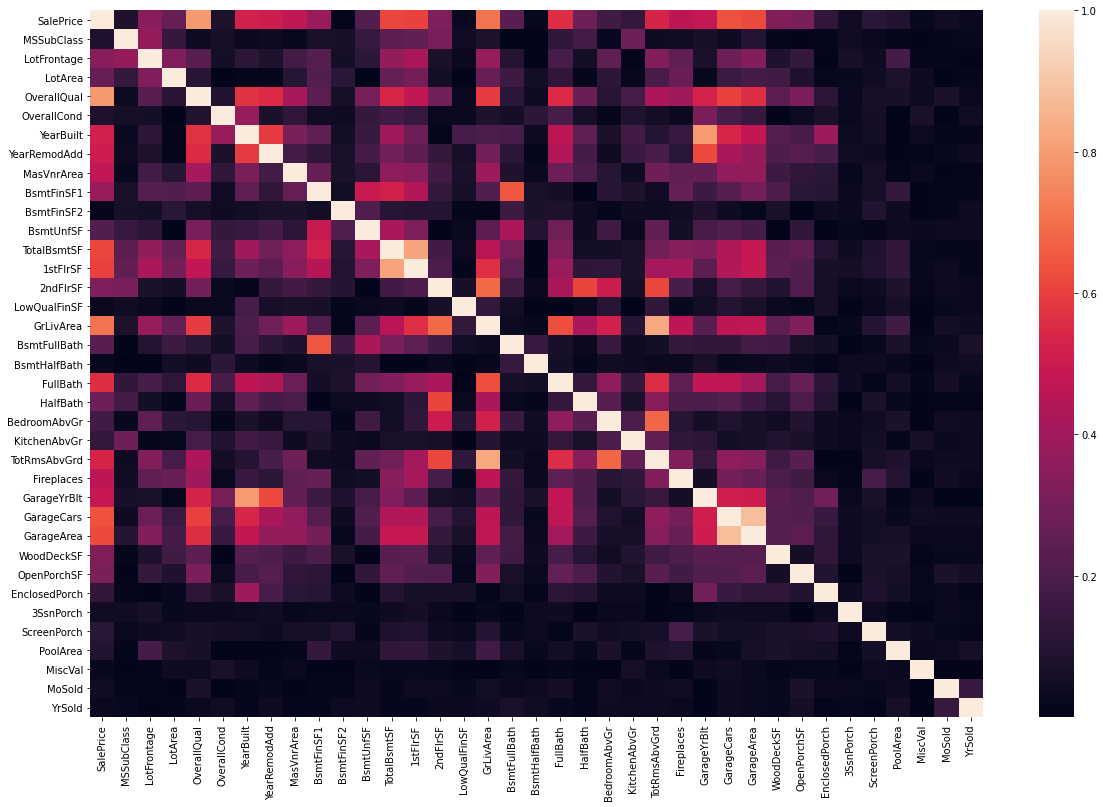

In [7]:
corr_matrix = df_train[list(df_train.columns)[:len(list(df_train.columns))-1]].corr()

corr_matrix = corr_matrix.abs()

high_corr_var=np.where(corr_matrix>0.6)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

print(high_corr_var)


fig, ax = plt.subplots(figsize=(20,13))         # Sample figsize in inches
sns.heatmap(corr_matrix)

In [8]:
corr_with_target = df_train.corr().abs()['SalePrice']
elements_to_exclude = []


for corr_pair in high_corr_var:
    el_1 = corr_pair[0]
    el_2 = corr_pair[1]
    if el_1 in elements_to_exclude or el_2 in elements_to_exclude:
        continue
    else:
        if corr_with_target[el_1] > corr_with_target[el_2]:
            # print('el_1', el_1, 'el_2', el_2, 'corr_with_target[el_1]', corr_with_target[el_1], 'corr_with_target[el_2]', corr_with_target[el_2], 'удаляем ' + str(el_2))
            elements_to_exclude.append(el_2)
        else:
            # print('el_1', el_1, 'el_2', el_2, 'corr_with_target[el_1]', corr_with_target[el_1], 'corr_with_target[el_2]', corr_with_target[el_2], 'удаляем ' + str(el_1))
            elements_to_exclude.append(el_1)

df_train = df_train.drop(columns=elements_to_exclude)
df_test = df_test.drop(columns=elements_to_exclude)

# Преобразование object

In [26]:
def get_object_col_vc(df, df_train, target_name='SalePrice'):
    df_dtypes = df.dtypes.reset_index()
    df_dtypes.columns = ['feature', 'dtype']

    df_obj_dtypes = df_dtypes[df_dtypes['dtype'] == 'object']

    for obj_col in df_obj_dtypes['feature']:
        df_for_mapping = df_train[[obj_col, target_name]].groupby(obj_col).median().sort_values(target_name).reset_index().reset_index().drop(target_name, axis=1)
        df_for_mapping.columns = ['map_value', obj_col]
        map_dict = dict(zip(df_for_mapping[obj_col], df_for_mapping['map_value']))
        df[obj_col] = df[obj_col].map(map_dict)



    return df

get_object_col_vc(df_train, df_train).info()

# df_train = get_object_col_vc(df_train)
# df_test = get_object_col_vc(df_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 65 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int64  
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   int64  
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   int64  
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   int64  
 12  Condition1     1460 non-null   int64  
 13  Condition2     1460 non-null   int64  
 14  BldgType       1460 non-null   int64  
 15  HouseStyle     1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

# Модель

In [ ]:
import xgboost
from sklearn.model_selection import train_test_split  
from sklearn import metrics
XGBReg = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [ ]:
X = df_train[list(df_train.columns)[1:]]
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [ ]:
XGBReg = XGBReg.fit(X_train, y_train)

In [ ]:
xgb_predictions = XGBReg.predict(X_test)

In [ ]:
metrics.mean_squared_log_error(xgb_predictions, y_test)

In [ ]:
df_test

In [ ]:
final_predictions = XGBReg.predict(df_test)

In [ ]:
final_predictions

In [ ]:
df_test['SalePrice'] = final_predictions

In [ ]:
df_test[['SalePrice']].to_csv('first_better_attempt.csv')

In [ ]:
df_metrics_check = pd.DataFrame(y_test)
df_metrics_check['y_pred'] = xgb_predictions

In [ ]:
df_metrics_check['SalePrice'] = df_metrics_check['SalePrice'].apply(lambda x : np.log(x))
df_metrics_check['y_pred'] = df_metrics_check['y_pred'].apply(lambda x : np.log(x))
df_metrics_check

In [ ]:
metrics.mean_squared_error(df_metrics_check['SalePrice'], df_metrics_check['y_pred'])

In [ ]:
def mistake_prob(amt_mistakes, mistake_prob):
    for i in range(amt_mistakes):
        if i == 0:
            not_mistake = 1 - mistake_prob[i]
        else:
            not_mistake *= (1 - mistake_prob[i])

    return 1 - not_mistake

for i in range(1, 6):
    print(mistake_prob(amt_mistakes=i, mistake_prob=[0.1, 0.1, 0.5, 0.1, 0.1]))